In [ ]:
using BenchmarkTools
using Plots

include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

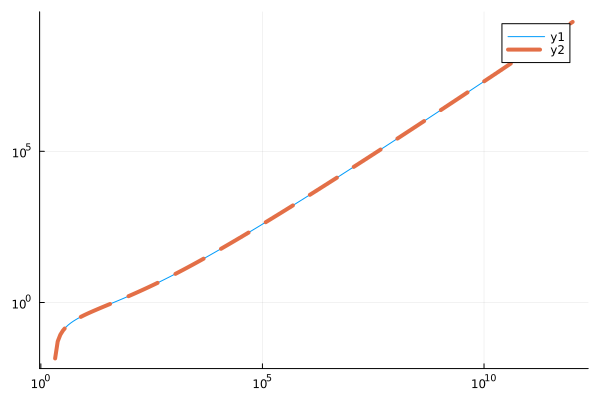

In [217]:
using Plots

Mhost_init = 1e+12
Mres = 1e+0

Mhost = 10.0.^range(log10(2.1*Mres), log10(Mhost_init), 200)

function_P, function_F = cj.interpolate_functions_PF(Mhost_init, Mres)

plot(Mhost, cj.mean_number_progenitors.(Mhost/2.0, Mhost, Mres), xscale=:log10,  linestyle=:solid, yscale=:log10)
plot!(Mhost, function_P.(Mhost, Mres), xscale=:log10, linestyle=:dash, linewidth=4, yscale=:log10)

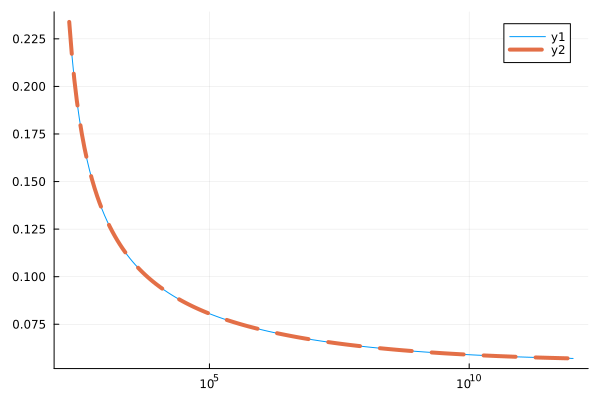

In [218]:
using Plots

Mhost_init = 1e+12
Mres = 1e+2

Mhost = 10.0.^range(log10(2*Mres), log10(Mhost_init), 200)

function_P, function_F = cj.interpolate_functions_PF(Mhost_init, Mres)

plot(Mhost, cj.mass_fraction_unresolved.(Mhost, Mres), xscale=:log10,  linestyle=:solid)
plot!(Mhost, function_F.(Mhost), xscale=:log10, linestyle=:dash, linewidth=4)

In [ ]:
using Plots

M1   = 1e+12
M2 = 10.0.^range(2, log10(M1), 200)

plot(M2[M2.>1e+8], cj.pdf_progenitors.(M2[M2.>1e+8], M1, 1e+8), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+5], cj.pdf_progenitors.(M2[M2.>1e+5], M1, 1e+5), xscale=:log10, yscale=:log10)
plot!(M2[M2.>1e+2], cj.pdf_progenitors.(M2[M2.>1e+2], M1, 1e+2), xscale=:log10, yscale=:log10)

In [ ]:
using Plots

M1   = 1e+12
M2 = 10.0.^range(0, log10(M1), 100)

#plot(M2, cj.cmf_progenitors.(M2, M1, 1e+8) .- 0.2, xscale=:log10)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+5).- 0.2, xscale=:log10)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+2).- 0.2, xscale=:log10)

M1   = 250
M2 = 10.0.^range(1.5, log10(M1), 1000)

#plot(M2, cj.cmf_progenitors.(M2, M1, 1e+8).- 0.2, xscale=:log10, linestyle=:dash)
#plot!(M2, cj.cmf_progenitors.(M2, M1, 1e+5).- 0.2, xscale=:log10, linestyle=:dash)
plot(M2, cj.cmf_progenitors.(M2, M1, 1e+2), xscale=:log10, linestyle=:dash)

In [ ]:
itp_z_vs_Δω = cj.interpolate_functions_z()

In [ ]:
subhalo_mass1, m_host1, z_steps1, z_acc1 = cj.subhalo_mass_function(1e+12, 1e+8, z_vs_Δω = itp_z_vs_Δω)

In [ ]:
subhalo_mass2, m_host2, z_steps2, z_acc2 = cj.subhalo_mass_function(1e+12, 1e+5, z_vs_Δω = itp_z_vs_Δω)

In [ ]:
subhalo_mass3, m_host3, z_steps3, z_acc3 = cj.subhalo_mass_function(1e+12, 1e+6,  z_vs_Δω = itp_z_vs_Δω)

In [ ]:
using Plots

m_array = 10.0.^range(-8, stop=1, length=1000)
#CMF1 = [count(x -> x > m, subhalo_mass1) for m in m_array]
CMF2 = [count(x -> x > m, subhalo_mass2) for m in m_array]
CMF3 = [count(x -> x > m, subhalo_mass3) for m in m_array]

#plot(m_array[CMF1 .> 0], CMF1[CMF1 .> 0], xscale=:log10, yscale=:log10, color=:blue)
plot(m_array[CMF2 .> 0], CMF2[CMF2 .> 0], xscale=:log10, yscale=:log10, color=:red)
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, color=:green)

In [ ]:
using SpecialFunctions
using LsqFit

function γ2(γ1::Real, α1::Real, α2::Real, β::Real, ζ::Real) 
    int1 =  β.^(.-(2.0.-α1)./ζ) .* gamma.((2.0.-α1)./ζ) .*  gamma_inc.((2.0.-α1)./ζ, β)[1] ./ ζ 
    int2 =  β.^(.-(2.0.-α2)./ζ) .* gamma.((2.0.-α2)./ζ) .*  gamma_inc.((2.0.-α2)./ζ, β)[1] ./ ζ 
    return (1.0 .- γ1 .* int1) ./  int2
end

function fitting_function(m_m0, γ1, α1, α2, β, ζ)
    if α1 > 2 || α1 < 1 || α2 > 2 || α2 < 1 || β < 0 || ζ < 0 || γ1 < 0
        return Inf
    end
    return γ1./ζ .* ((m_m0).^(1.0.-α1) .* expint.((α1.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α1.-1.0)./ζ .+ 1.0, β)) .+  γ2(γ1, α1, α2, β, ζ)./ζ .* ((m_m0).^(1.0.-α2) .* expint.((α2.-1.0)./ζ .+ 1.0, β.*(m_m0).^ζ) .- expint.((α2.-1.0)./ζ .+ 1.0, β)) 
end

p0 = [0.019, 1.94, 1.58, 24, 3.4]

model(t, p) = @. log10.(fitting_function(10.0.^t, p[1], p[2], p[3], p[4], p[5]))

fit = curve_fit(model, log10.(m_array[CMF3 .> 0]), log10.(CMF3[CMF3 .> 0]), p0)

println(fit.param)
println(γ2(fit.param...))

res = 10.0.^model(log10.(m_array), fit.param) #fitting_function(1e+12 .* m_array, 1e+12, fit.param...)
plot(m_array[res .> 0], res[res .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])
plot!(m_array[CMF3 .> 0], CMF3[CMF3 .> 0], xscale=:log10, yscale=:log10, ylim=[1e-1, 1e+5])

In [ ]:
#plot(z_steps1, m_host1, yscale=:log10, color=:blue)
plot(z_steps2, m_host2, yscale=:log10, color=:red)
plot!(z_steps3, m_host3, yscale=:log10, color=:green)

In [ ]:
#plot(subhalo_mass1, z_acc1, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)
plot(subhalo_mass2, z_acc2, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)
plot!(subhalo_mass3, z_acc3, seriestype=:scatter, xscale=:log10, markersize = 2, yscale=:log10)

In [ ]:
import StatsBase as SB
using Plots

id_6 = (subhalo_mass2 .> 1e-6) .& (subhalo_mass2 .< 1e-5)
id_5 = (subhalo_mass2 .> 1e-5) .& (subhalo_mass2 .< 1e-4)
id_4 = (subhalo_mass2 .> 1e-4) .& (subhalo_mass2 .< 1e-3)
id_3 = (subhalo_mass2 .> 1e-3) .& (subhalo_mass2 .< 1e-2)
#println(count(x -> x === true, id_4))

#result6 = SB.fit(Histogram, log10.(z_acc3[id_6]), nbins=40)
#result5 = SB.fit(Histogram, log10.(z_acc3[id_5]), nbins=40)
#plot(result6.edges[1][2:end], log10.(result6.weights), st=:stairs)
#plot!(result5.edges[1][2:end], log10.(result5.weights), st=:stairs)

histogram(log10.(z_acc2[id_6]), normalize=:pdf)
histogram!(log10.(z_acc2[id_5]), normalize=:pdf)
histogram!(log10.(z_acc2[id_4]), normalize=:pdf)

In [ ]:
#Mres = 1e+2

#println((1.0 .- 10.0.^random))

#plot(heatmap(random, log10.(M1_array), log10.(cj.cmf_inv_progenitors.((1.0 .- 10.0.^random)', M1_array, 1e+5))), c = :thermal)

In [150]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

mres = 1e+6
mhost = 1e+12

itp_S_vs_mass, itp_dS_vs_mass = cj.interpolate_S_vs_mass()
cj._save_cmf_inv_progenitors(mhost, mres, itp_S_vs_mass, itp_dS_vs_mass)

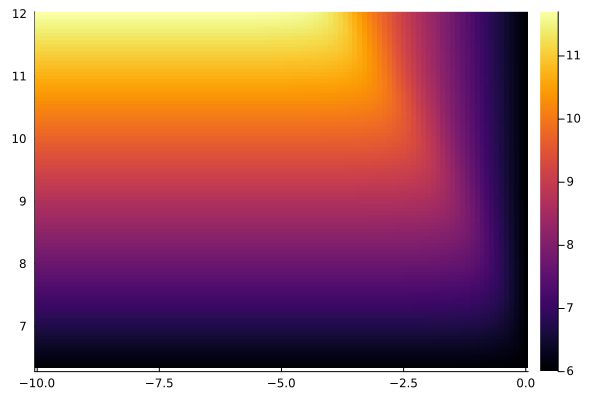

In [151]:
using Plots

q = range(-10, 0, length=101)
m1_array = 10.0.^range(log10(2.0001*mres), log10(mhost), length=101)

func = cj._load_cmf_inv_progenitors(mhost, mres, itp_S_vs_mass, itp_dS_vs_mass)
plot(heatmap(q, log10.(m1_array), log10.(func.((1.0 .- 10.0.^q)', m1_array))), c = :thermal)

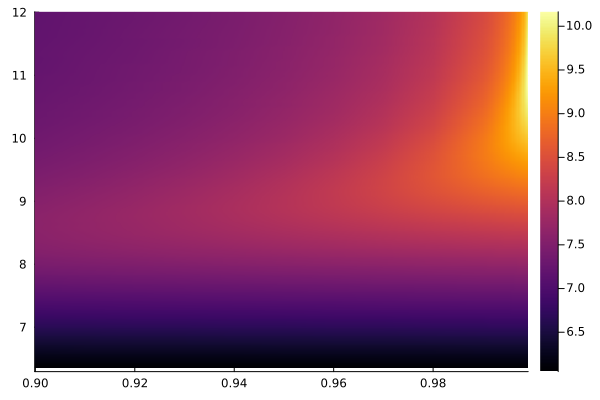

In [152]:
using Plots

p = range(0.9, 0.999, length=401)
m1_array = 10.0.^range(log10(2.0001*mres), log10(mhost), length=401)

func = cj._load_cmf_inv_progenitors(mhost, mres, itp_S_vs_mass, itp_dS_vs_mass)
plot(heatmap(p, log10.(m1_array), log10.(func.(p', m1_array))), c = :thermal)

In [220]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

itp_z_vs_Δω = cj.interpolate_functions_z()

z_bins_2, mass_edges_2, z_edges_2 = cj.subhalo_mass_function_binned(1e+12, 1e+6, z_vs_Δω = itp_z_vs_Δω)

┌ Info: ===========================================
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:435
┌ Info: INITIALISATION
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:436
┌ Info: | Precomputing or loading the interpolation tables
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:437


This file is already cached


┌ Info: INITIALISATION DONE: STARTING MERGER TREE
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:456
┌ Info: ("| i = ", 0x0000000000001393, ", z = ", 0.08034548276673194, ", n_sub = ", 0x00000000000001df)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:484


MERGER TREE OVER
| 63857 interations were done
| final redshift : 23.056567335653217
| 6370 subhalos found


┌ Info: ("| i = ", 0x0000000000002726, ", z = ", 0.17117062487945156, ", n_sub = ", 0x00000000000003f3)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:484
┌ Info: ("| i = ", 0x0000000000003ab9, ", z = ", 0.2990749347392424, ", n_sub = ", 0x00000000000005ea)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:484
┌ Info: ("| i = ", 0x0000000000004e4c, ", z = ", 0.42447076968872943, ", n_sub = ", 0x00000000000007e1)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:484
┌ Info: ("| i = ", 0x00000000000061df, ", z = ", 0.5564066697339003, ", n_sub = ", 0x0000000000000a07)
└ @ Main.Cosmojuly.MassFunction /Users/gaetanfacchinetti/Documents/work/codes/env_DarkUniverse/Cosmojuly.jl/src/MassFunction.jl:484
┌ Info: ("| i = ", 0x0000000000007572, ", z = ", 0.6894148

(UInt64[0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; … ; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000; 0x0000000000000000 0x0000000000000000 … 0x0000000000000000 0x0000000000000000], [1.0e-6, 1.2589254117941661e-6, 1.584893192461114e-6, 1.9952623149688787e-6, 2.5118864315095823e-6, 3.162277660168379e-6, 3.981071705534969e-6, 5.011872336272725e-6, 6.30957344480193e-6, 7.943282347242822e-6  …  0.12589254117941673, 0.15848931924611134, 0.19952623149688797, 0.251188643150958, 0.31622776601683794, 0.39810717055349726, 0.5011872336272722, 0.6309573444801932, 0.7943282347242815, 1.0], [1.0e-9, 1.7113283041617775e-9, 2.9286445646252374e-9, 5.011872336272715e-9, 8.576958985908947e-9, 1.4677992676220705e-8, 2.511886431509582e-8, 4.298662347082281e-8, 7.356422544596406e-8, 1.2589254117941662e-7  …  794.3282347242813, 1359.3563908785254, 2326.30506715362

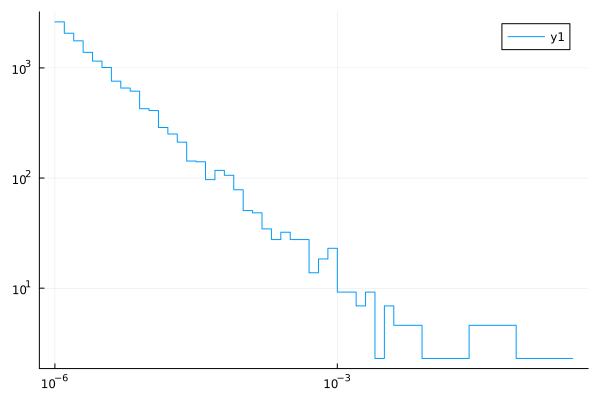

In [221]:
using Plots

#mass_bins = sum(z_bins, dims=2)[:]
#edges = mass_edges[1:end-1][mass_bins .> 0]


mass_bins_2 = sum(z_bins_2, dims=2)[:]
edges_2 = mass_edges_2[1:end-1][mass_bins_2 .> 0]

#plot(edges,  log(10) .* mass_bins[mass_bins .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)
plot(edges_2,  log(10) .* mass_bins_2[mass_bins_2 .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)
#plot!(edges, 0.02*edges.^(-0.89), xscale=:log10, yscale=:log10)

60×60 Matrix{UInt64}:
 0x0000000000000000  0x0000000000000000  …  0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000  …  0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
                  ⋮                      ⋱  
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000     0x0000000000000000
 0x0000000000000000  0x0000000000000000  …  0x00000

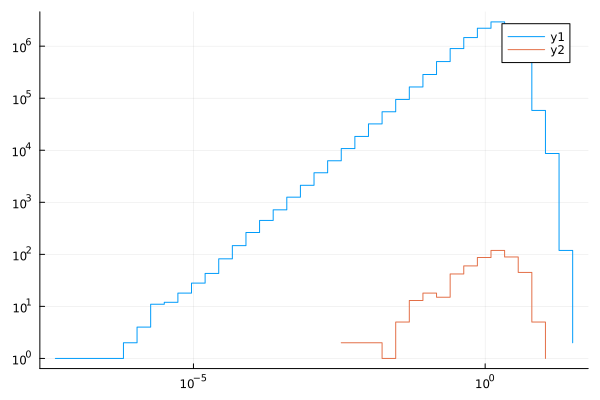

In [30]:
using Plots

edges = z_edges[1:end-1]
data1 = z_bins[1,:]
data2 = z_bins[50,:]

plot(edges[data1 .> 0], data1[data1 .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)
plot!(edges[data2 .> 0], data2[data2 .> 0], xscale=:log10, yscale=:log10, seriestype=:stairs)

In [14]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj
using BenchmarkTools

itp_S_vs_mass, itp_dS_vs_mass = cj.interpolate_S_vs_mass()

#@benchmark cj.mean_number_progenitors(1e+11, 1e+12, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  404.458 μs …   6.639 ms  ┊ GC (min … max): 0.00% … 93.03%
 Time  (median):     413.291 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   441.170 μs ± 321.186 μs  ┊ GC (mean ± σ):  4.57% ±  5.81%

  ▄▃█▇▄▃▃▂▂▁▁▁▁▁                                                ▁
  ████████████████████▇▇▇▆▅▆▆▆▆▆▆▅▅▅▅▅▅▄▆▅▅▅▅▅▅▅▄▃▅▄▄▃▂▄▂▃▄▃▄▃▄ █
  404 μs        Histogram: log(frequency) by time        584 μs <

 Memory estimate: 256.75 KiB, allocs estimate: 13358.

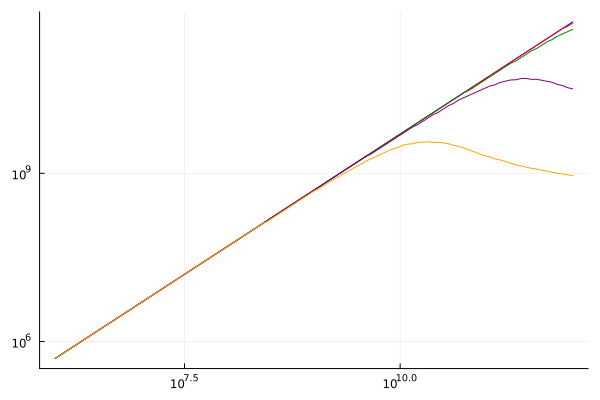

In [139]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

m1_array = 10.0.^range(log10(1e+6), log10(mhost), length=101)
res1 = cj.cmf_inv_progenitors.(0.9999999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res2 = cj.cmf_inv_progenitors.(0.999999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res3 = cj.cmf_inv_progenitors.(0.99999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res4 = cj.cmf_inv_progenitors.(0.9999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)
res5 = cj.cmf_inv_progenitors.(0.999999, m1_array, 1e+2, itp_S_vs_mass, itp_dS_vs_mass)

plot(m1_array[res1 .> 0], res1[res1 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:blue)
plot!(m1_array[res2 .> 0], res2[res2 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:red)
plot!(m1_array[res3 .> 0], res3[res3 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:green)
plot!(m1_array[res4 .> 0], res4[res4 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:purple)
plot!(m1_array[res5 .> 0], res5[res5 .> 0], xscale=:log10, yscale=:log10, legend = false, color=:orange)

In [201]:
n_bins     = trunc(Int64, log10.(mhost/mres)) * 10
mass_edges = 10.0.^range(log10(mres/mhost), 0, n_bins+1)
println(mass_edges[1])
findfirst(1.0000e+6 / mhost .< mass_edges)

1.0e-6


2

In [238]:
function foo(x)
    (x > 0 && return -2) || (return 3)
end

foo(-10)

3

In [11]:
include("../src/Cosmojuly.jl")
import .Cosmojuly as cj

In [16]:
cj.mean_number_progenitors(4e+2, 1e+12, 1e+2, method=:quadgk, rtol=1)

1.9527590081604827e7

In [32]:
function foo(z::Real; y=2, kws...)
    return z + y + kws[:val]
end

#foo(10, y=4, val=2)

function foo2(z::Real; y=2, kws...)
    return foo(z, y=y; kws...)
end

foo2(10, y=4, val=2)

16